# Interpolation -- Méthodes

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from IPython.core.display import HTML
def css_styling():
    styles = open("rise.css", "r").read()
    return HTML(styles)
css_styling();

import numpy as np
import matplotlib.pyplot as plt
import itertools as it

Dans ce TP, vous allez programmer les différentes méthodes de calcul du polynôme interpolateur de Lagrange et les tester sur les quelques fonctions suivantes :
\begin{align}
f_0(x) &= \exp(-3(x-1.2)^2), &
f_1(x) &= \frac{x^2-2}{1+2x},\\
f_2(x) &= \frac{1}{1+(x-1.5)^2},&
f_3(x) &= \frac{\sin(2\pi x)}{1.1 - \sin(\pi x)}.
\end{align}

### Question 1
Définissez les fonctions $f_0,\ldots,f_3$ et tracez les sur l'intervalle $[1,3]$.

In [2]:
f0 = lambda x: np.exp(-3*(x-1.2)**2)
f1 = lambda x: (x**2-2) / (1+2*x)
f2 = lambda x: 1./(1+(x-1.5)**2)
f3 = lambda x: np.sin(2*np.pi*x) / (1.1 - np.sin(np.pi*x))

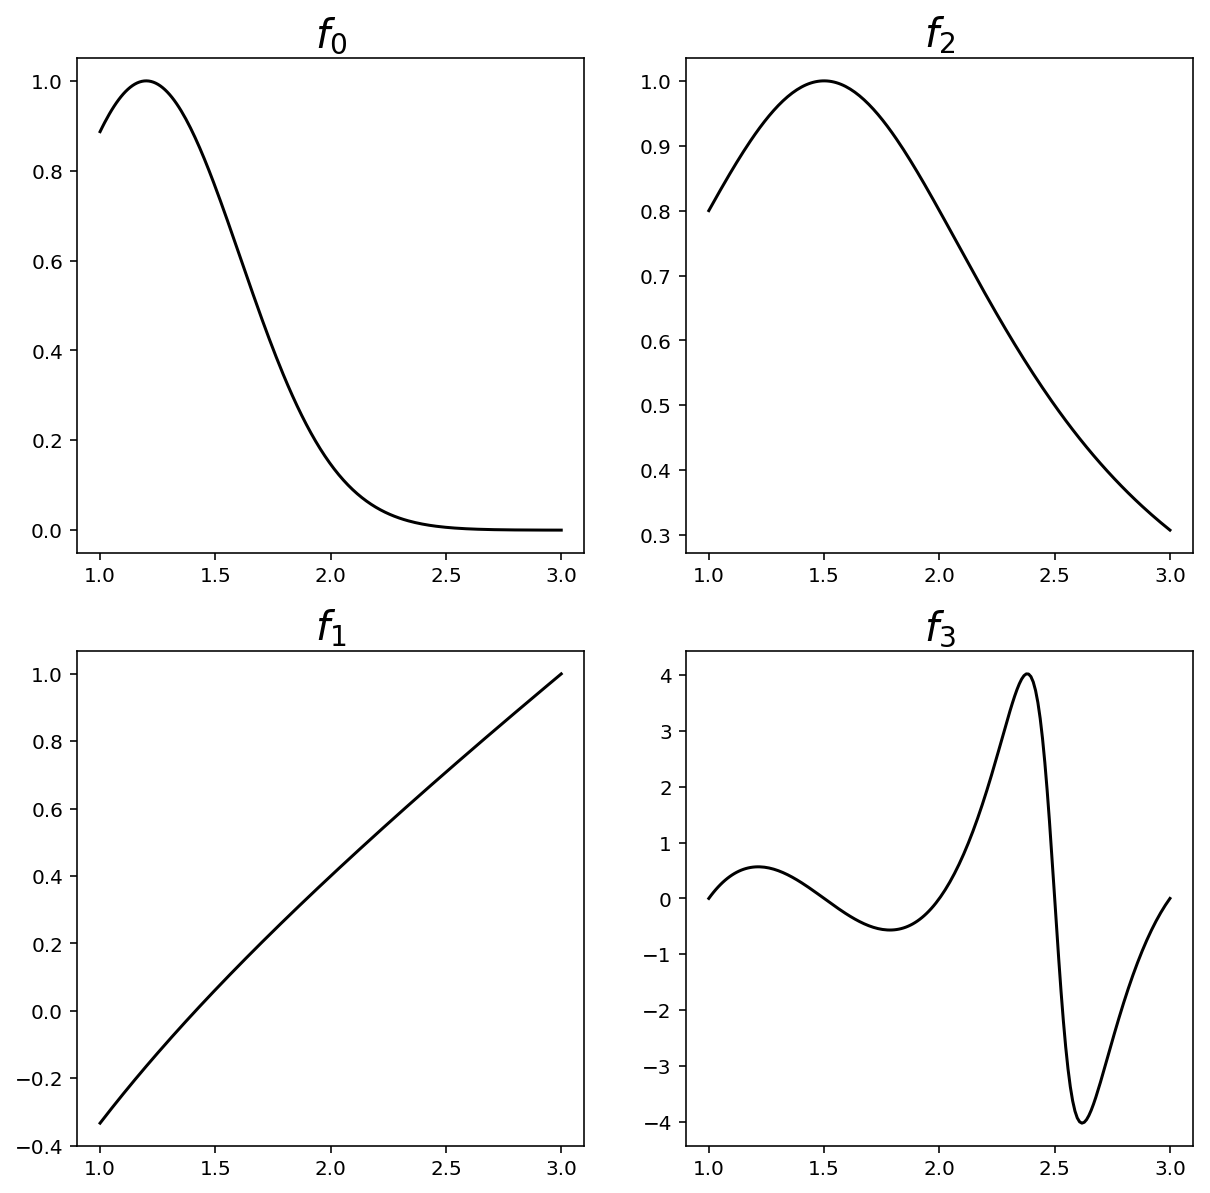

In [3]:
fig, ax = plt.subplots(2, 2, figsize = (10, 10))
xx = np.linspace(1, 3, 200)
for i, f in enumerate([f0, f1, f2, f3]):
    ax[i%2, i//2].plot(xx, f(xx), 'k')
    ax[i%2, i//2].grid(False)
    ax[i%2, i//2].set_title(r'$f_{0}$'.format(i), fontsize=20)

In [5]:
def figure(method):
    fig, ax = plt.subplots(2, 2, figsize = (10, 10))
    xx = np.linspace(1, 3, 200)
    for i, f in enumerate([f0, f1, f2, f3]):
        ax[i%2, i//2].plot(xx, f(xx), 'k')
        ax[i%2, i//2].grid(False)
        ax[i%2, i//2].set_title(r'$f_{0}$'.format(i), fontsize=20)
        for N in [4, 8, 12, 16, 20]:
            x = np.linspace(1, 3, N)
            y = f(x)
            ax[i%2, i//2].plot(xx, method(x, y, xx), label = r'$N={0}$'.format(N))
        ax[i%2, i//2].legend(loc = 'best')

## Méthode de Vandermonde

### Question 2
Programmez une fonction `InterpVdM(x, y, xx)` qui prendra en arguments trois vecteurs : `x` et `y` de même taille `n` et `xx` de taille `N` et qui retournera l'évaluation aux points du vecteur `xx` du polynôme interpolateur de Lagrange aux points $(x_i,y_i)$, $1\leq i\leq n$. Le calcul du polynôme interpolateur devra être fait à l'aide de la méthode de Vandermonde. 

Pour évaluer le polynôme, vous utiliserez l'algorithme de Horner (que vous pourrez programmer dans une fonction séparée).

Tracez l'interpolée de Lagrange de chacune des quatre fonctions $(f_0,\ldots,f_3)$ en $N$ points équirépartis sur l'intervalle $[1,3]$. Pour chaque fonction, vous tracerez sur une même figure l'interpolée pour $N\in\lbrace 4, 8, 12, 16, 20\rbrace$.

Vous ajouterez une légende et un titre sur chacun de vos graphiques.

In [9]:
def Horner(p, x):
    y = 0
    for ak in p:
        y *= x
        y += ak
    return y

def InterpVdM(x, y, xx):
    """
    Interpolation with the Vandermonde method
    """
    x, y, xx = np.asanyarray(x, dtype = 'float64'), \
        np.asanyarray(y, dtype = 'float64'), \
        np.asanyarray(xx, dtype = 'float64')
    n = x.size
    if y.size != n:
        print('Error in InterpVdm: x and y do not have the same size')
    A = np.ones((n, n))
    for k in range(1,n):
        A[:, k] = A[:, k-1] * x
    p = np.linalg.solve(A, y)
    return Horner(p[::-1], xx) if xx.size != 1 else Horner(p[::-1], np.asscalar(xx))

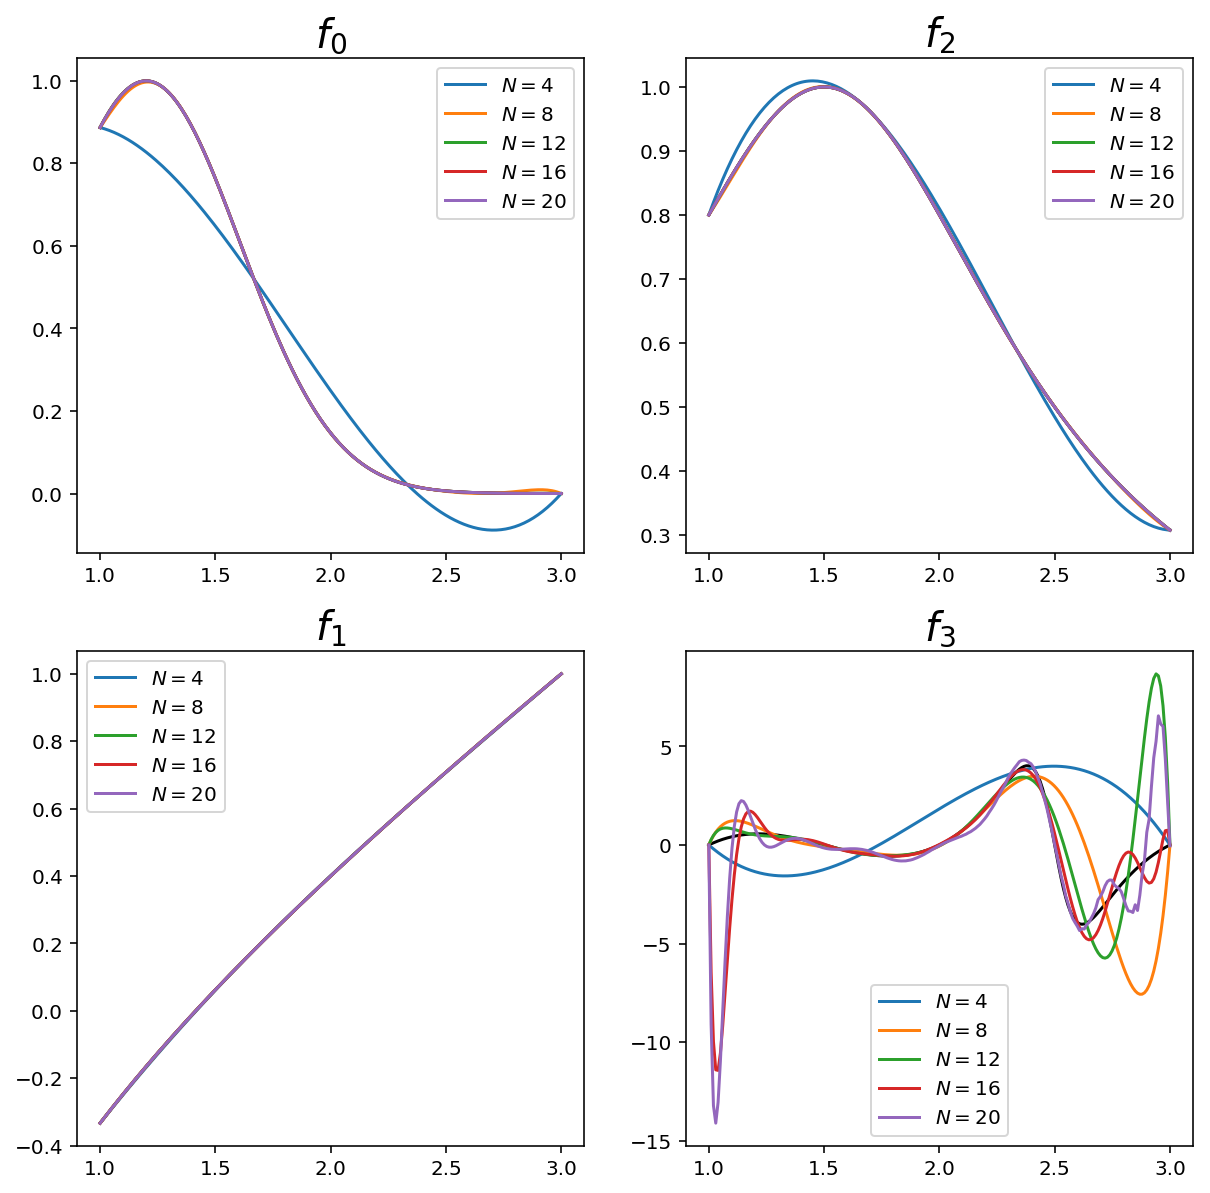

In [8]:
figure(InterpVdM)
    

## Méthode de Lagrange

### Question 3

Reprenez la question 2 en calculant le polynôme interpolateur par la formule de Lagrange. Vous ferez bien attention à traiter correctement la division par 0 dans cette formule.

In [10]:
def InterpLagrange(x, y, xx):
    """
    Interpolation using the Lagrange formula
    """
    x, y, xx = np.asanyarray(x, dtype = 'float64'), \
        np.asanyarray(y, dtype = 'float64'), \
        np.asanyarray(xx, dtype = 'float64')
    n = x.size
    if y.size != n:
        print('Error in InterpLagrange: x and y do not have the same size')
    w = np.ones((n,))
    for i in range(n):
        for j in it.chain(range(i), range(i+1, n)):
            w[i] *= (x[i] - x[j])
    weight = 1./w
    if xx.size == 1:
        N, D = 0., 0.
        for i in range(n):
            if xx == x[i]:
                return y[i]
            dxi = weight[i] / (xx-x[i])
            N += y[i] * dxi
            D += dxi
    else:
        N, D = np.zeros(xx.shape), np.zeros(xx.shape)
        ind = []
        for i in range(n):
            ind.append(np.where(xx == x[i]))      # indices where P(xi) = yi
            indloc = np.where(xx != x[i])
            dxi = weight[i] / (xx[indloc] - x[i]) # avoid divide by 0
            N[indloc] += y[i] * dxi
            D[indloc] += dxi
        for i in range(n): # fix yi in xi
            N[ind[i]], D[ind[i]] = y[i], 1.
    return N / D

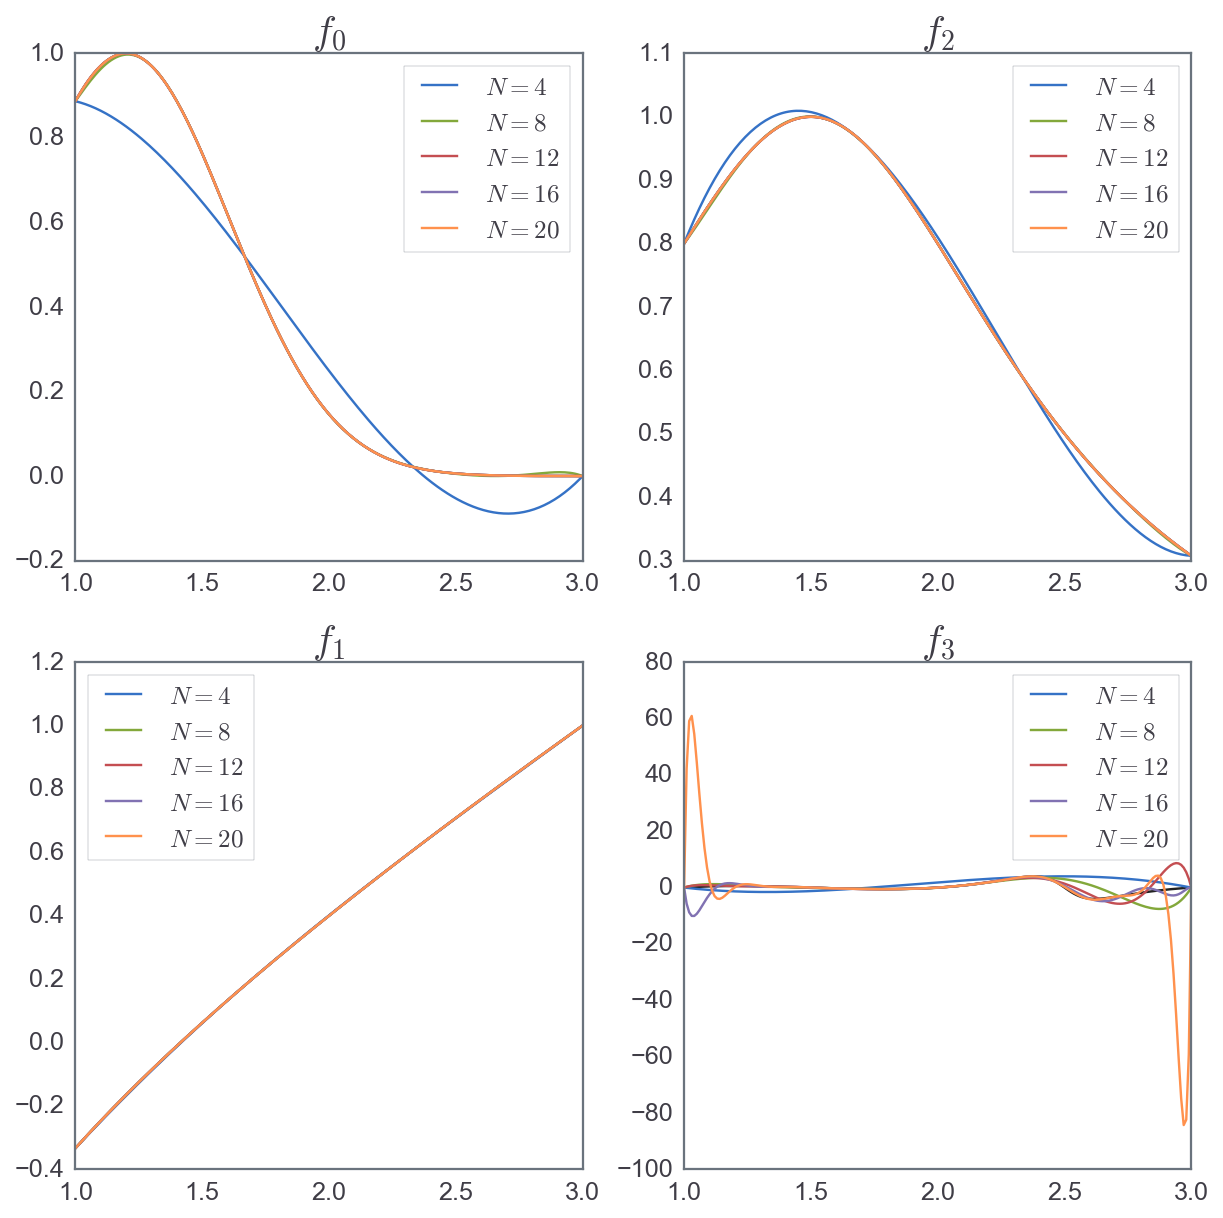

In [39]:
figure(InterpLagrange)

## Méthode de Neville

### Question 4

Reprenez la question 2 en utilisant la formule de récurrence proposée par Neville pour évaluer le polynôme interpolateur de Lagrange.

In [30]:
def InterpNeville(x, y, xx):
    """
    Interpolation with the Neville method
    """
    x, y, xx = np.asanyarray(x, dtype = 'float64'), \
        np.asanyarray(y, dtype = 'float64'), \
        np.asanyarray(xx, dtype = 'float64')
    n = x.size
    if y.size != n:
        print('Error in InterpNeville: x and y do not have the same size')
    yy = y[:,np.newaxis] * np.ones((1, *xx.shape))
    for j in range(2,n+1): # length of the vector (x_k,...,x_l)
        for l in range(n-1,j-2,-1):
            yy[l] = ((xx-x[l])*yy[l-1] - (xx-x[l+1-j])*yy[l]) / (x[l+1-j] - x[l])
    return yy[-1] if xx.size != 1 else np.asscalar(yy[-1])

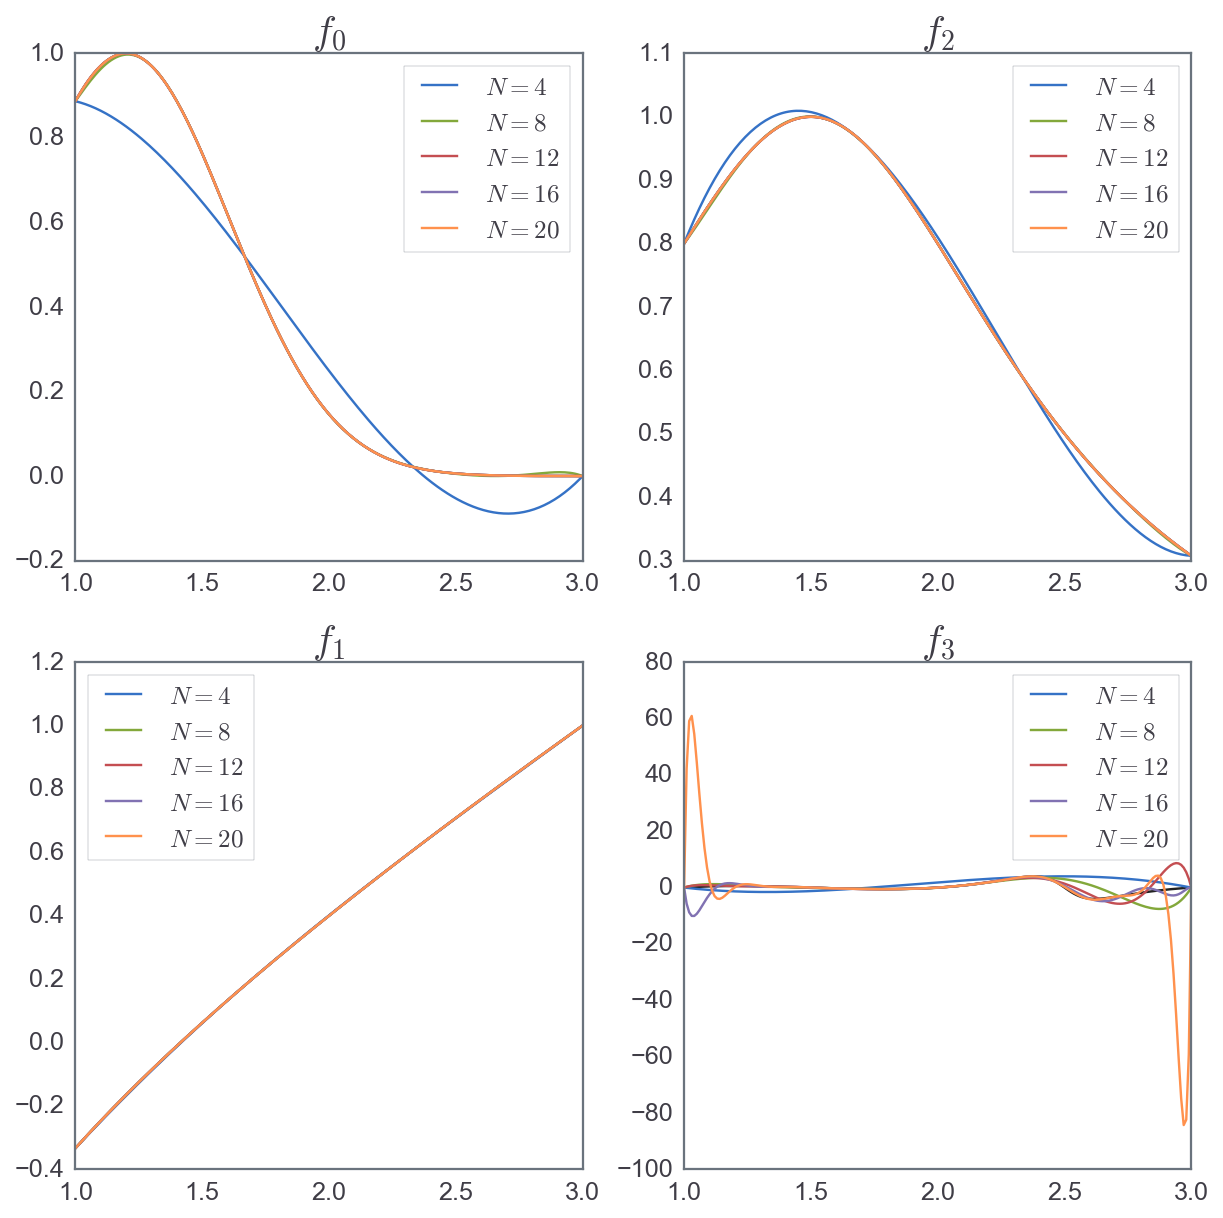

In [31]:
figure(InterpNeville)

## Méthode des différences divisées

### Question 5

Reprenez la question 2 en utilisant la méthode des différences divisées.

In [49]:
def InterpDivDiff(x, y, xx):
    """
    Interpolation with the divided differences method
    """
    x, y, xx = np.asanyarray(x, dtype = 'float64'), \
        np.asanyarray(y, dtype = 'float64'), \
        np.asanyarray(xx, dtype = 'float64')
    n = x.size
    if y.size != n:
        print('Error in InterpDivDiff: x and y do not have the same size')
    d = y.copy()
    for i in range(1, n):
        d[i:] = (d[i:] - d[i-1:-1]) / (x[i:] - x[:n-i])
    yy = d[-1]
    for k in range(n-2, -1, -1):
        yy *= xx - x[k]
        yy += d[k]
    return yy if xx.size != 1 else np.asscalar(yy)

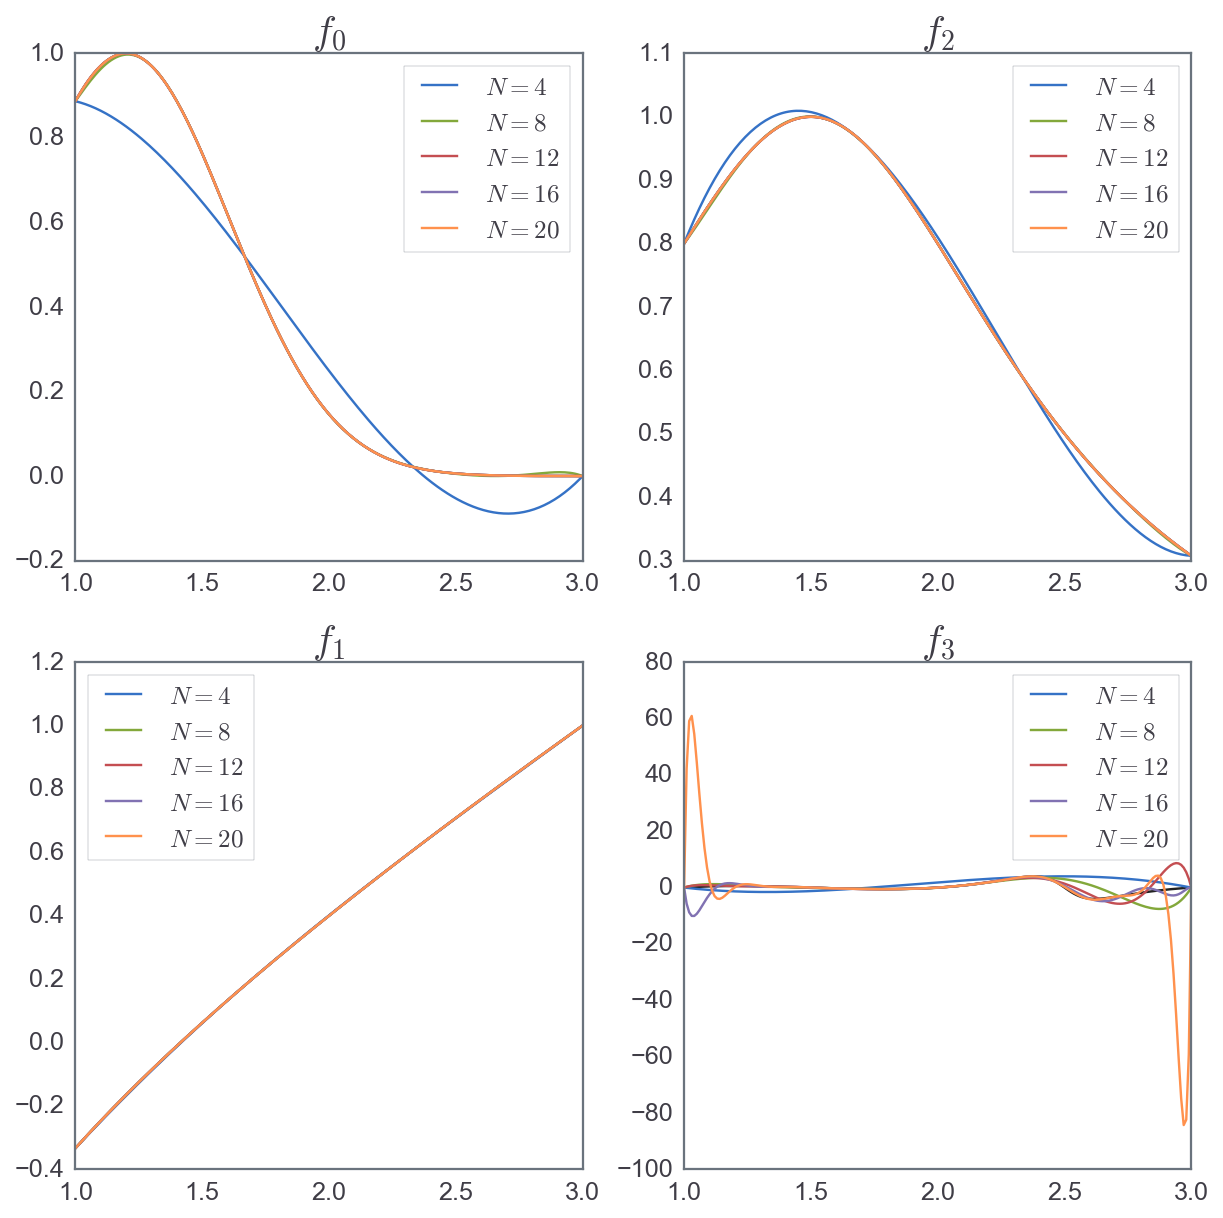

In [50]:
figure(InterpDivDiff)